# Home Credit Default Risk Analysis 
*Dimitar Vlassarev 2018*

**Plan for analysis:**
1. Pre-process data and split into X, y and Train/Test
2. Encode categorical variables
3. Impute missing values
4. Standardize features
5. PCA and pick number of components
6. Fit a reference Random Forest Model
7. Add SMOTE and ADASYN  due to imbalance and refit Random Forest Model
8. Optional - hyper-param tuning for Random Forest Model
9. Gluon + MXNet model compare to Random Forest Model
10. Try out SMOTE and or similar vs threshold adjustments and full minority injections in SGD
11. Optimize Random Forest Model
12. Explore other datasets and when not one-to-one variable select on aggregates and add columns to original set. Repeat 1-10 (possibly skipping non ANN steps)
13. Additional feature engineering and ANN tuning (architecture, activations, initialization)

## Load Libraries

In [1]:
from time import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, precision_score
from imblearn.over_sampling import SMOTE, ADASYN 

import mxnet as mx
from mxnet import gluon, autograd, symbol
from mxnet import ndarray as nd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Dimitar Vlassarev\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset Class
Carries some similarities to pipeline implementation but allows for more flexibility.

In [2]:
class dataset(object):
    """A dataset class that will take the data and do pre-processing and in some cases
    modeling of the data. Instance variable data will hold a Pandas dataframe.
    
        @param path (str): String to the csv file (can be zipped) to load.
        @param exclude (list): Columns that should not be normalized or imputed.
        @param target (str): Column that is the target variable."""
    
    def __init__(self, path, exclude, target):
        """Loads data."""
        self.data = pd.read_csv(path)
        self.exclude = exclude
        self.target = target
        self.feature_columns = [col for col in self.data.columns 
                                if col not in (exclude + [target])]
    
    def _clean_col_name(self, name):
        """Cleans column names from special characters and whitespaces.
            @param name (str): Input name.
            @return name (str): Cleaned up name."""

        name = name.upper()
        for c in ", /:":
            name = name.replace(c, "_")
        return(name)
    
    def describe_cardinality(self):
        """Prints the number of levels in each categorical column."""
        categorical_columns = self.data[self.feature_columns].select_dtypes([np.object]).columns
        for col_name in categorical_columns:
            col_data = self.data[col_name]
            print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

    def split_X_y(self):
        """Splits data columns into feature and target sets.
            @return (X, y) (tuple): Features and label."""
        X = self.data[self.feature_columns]
        y = self.data[self.target]
        return(X, y)
    
    def onehot(self, data):
        """Inplace, onehot encodes all the columns in the dataset.
            @param data (pandas.DataFrame): Data to encode.
            @return (data, data.columns): Cargorical variables encoded."""
        data = data.copy()
        categorical_columns = data.select_dtypes([np.object]).columns
        for col_name in categorical_columns:
            dummy_cols = pd.get_dummies(data[col_name])
            dummy_cols.columns = ["{}_{}".format(col_name, self._clean_col_name(dummy_name)) 
                                  for dummy_name in dummy_cols]
            data = data.merge(
                dummy_cols,
                left_index=True,
                right_index=True)
            data = data.drop(col_name, axis=1)
        return(data, data.columns)
    
    def impute(self, data, mode="fit_transform"):
        """Inplace, impute all columns with averages.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @param mode (str): Specifies whether to fit, fit_transform or transform.
            @return data (pandas.DataFrame): Imputed data."""
        if "fit" in mode:
            self.imp = Imputer().fit(data)
        if "transform" in mode:
            return(pd.DataFrame(self.imp.transform(data), columns=data.columns))
        
    def standardize(self, data, mode="fit_transform"):
        """Inplace, mean and std normalizes all columns except exclude.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @param mode (str): Specifies whether to fit, fit_transform or transform.
            @return data (pandas.DataFrame): Standardized data."""
        if "fit" in mode:
            self.standard = StandardScaler().fit(data)
        if "transform" in mode:
            return(pd.DataFrame(self.standard.transform(data), columns=data.columns))
    
    def pca(self, data, n_components=None, plot=True, mode="fit_transform"):
        """Runs PCA on the data and explores the number of components needed.
            @param n_components (int): Number of max components to consider.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @param mode (str): Specifies whether to fit, fit_transform or transform.
            @return data (pandas.DataFrame): PCA transformed data."""
        df = data.copy()
        if "fit" in mode:
            if not n_components:
                n_components = df.shape[1]
            pca = PCA(n_components=n_components)
            self.pca_model = pca.fit(df)

            if plot:
                matplotlib.rcParams.update({'font.size': 16})
                plt.figure(figsize=(16, 9))
                plt.plot(range(1, n_components + 1), 
                         np.cumsum(pca.explained_variance_ratio_),
                        linewidth=3, alpha=0.7, color="r")
                plt.title("Variance Explained vs Number of Components")
                plt.xlabel("Number of principal components")
                plt.ylabel("Relative variance explained")
                plt.ylim((0, 1.01))
                plt.grid(alpha=0.5)
        if "transform" in mode:
            return(self.pca_model.transform(df))
        
    def split_train_test(self, X, y, test_size=0.2):
        """Splits feature and target data sets into test and train.
            @param X (pandas.DataFrame): X data
            @param y (series): y data
            @param test_size (float): fraction of data for test
            @return X_train, X_test, y_train, y_test (tuple): split data"""
        return(train_test_split(X, y, test_size=test_size, random_state=757))
    
    def minority_oversample(self, X, y, mode="S"):
        """Oversamples minority class to balance it.
            @param X (pandas.DataFrame): X data
            @param y (series): y data
            @param mode (string): S for SMOTE or A for ADASYN
            @return X, y where X and y have been balanced (with minority oversampling)"""
        if mode == "S":
            self.sm = SMOTE(random_state=434)
            return(self.sm.fit_sample(X, y))
        elif mode == "A":
            self.ad = ADASYN(random_state=232)
            return(self.ad.fit_sample(X, y))
        else:
            raise(Exception("Invalid mode value."))

## Pre-Processing Data

In [3]:
# Number of principal components
n_components = 170

NAME_CONTRACT_TYPE           has  2 levels.
CODE_GENDER                  has  3 levels.
FLAG_OWN_CAR                 has  2 levels.
FLAG_OWN_REALTY              has  2 levels.
NAME_TYPE_SUITE              has  8 levels.
NAME_INCOME_TYPE             has  8 levels.
NAME_EDUCATION_TYPE          has  5 levels.
NAME_FAMILY_STATUS           has  6 levels.
NAME_HOUSING_TYPE            has  6 levels.
OCCUPATION_TYPE              has 19 levels.
WEEKDAY_APPR_PROCESS_START   has  7 levels.
ORGANIZATION_TYPE            has 58 levels.
FONDKAPREMONT_MODE           has  5 levels.
HOUSETYPE_MODE               has  4 levels.
WALLSMATERIAL_MODE           has  8 levels.
EMERGENCYSTATE_MODE          has  3 levels.


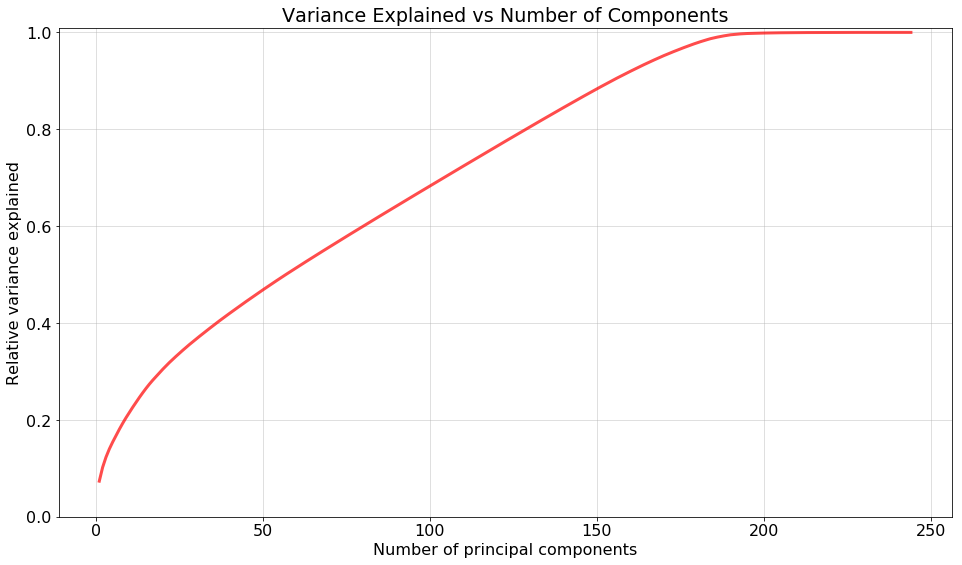

In [32]:
# Pre-processing
app = dataset(r"data/application_train.csv.zip", ["SK_ID_CURR"], "TARGET")
app.describe_cardinality()
app.X, app.y = app.split_X_y()
app.X, app.feature_columns = app.onehot(app.X)
app.X_train, app.X_test, app.y_train, app.y_test = app.split_train_test(app.X, app.y)

app.X_train = app.impute(app.X_train)
app.X_train = app.standardize(app.X_train)
app.pca(app.X_train, mode="fit")
app.X_train = app.pca(app.X_train, mode="fit_transform", n_components=n_components, plot=False)

app.X_test = app.impute(app.X_test, mode="transform")
app.X_test = app.standardize(app.X_test, mode="transform")
app.X_test = app.pca(app.X_test, mode="transform")

## Random Forest First Look

In [4]:
rfc = RandomForestClassifier(max_depth=7, random_state=0, n_estimators=50)
rfc.fit(app.X_train, app.y_train)

rfc_mo_s = RandomForestClassifier(max_depth=7, random_state=0, n_estimators=50)
rfc_mo_s.fit(*app.minority_oversample(app.X_train, app.y_train, mode="S"))

rfc_mo_a = RandomForestClassifier(max_depth=7, random_state=0, n_estimators=50)
rfc_mo_a.fit(*app.minority_oversample(app.X_train, app.y_train, mode="A"))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Random Forest Classifier
Train Accuracy: 0.919
Test Accuracy:  0.920
Confusion Matrix for 0.1 threhold.
[[46542 10032]
 [ 2867  2062]]
Area Under the Curve
0.6908036422857347
Random Forest Classifier
Train Accuracy: 0.695
Test Accuracy:  0.682
Confusion Matrix for 0.1 threhold.
[[    0 56574]
 [    0  4929]]
Area Under the Curve
0.6723287022450511
Random Forest Classifier
Train Accuracy: 0.679
Test Accuracy:  0.667
Confusion Matrix for 0.1 threhold.
[[    0 56574]
 [    0  4929]]
Area Under the Curve
0.6721247975001159


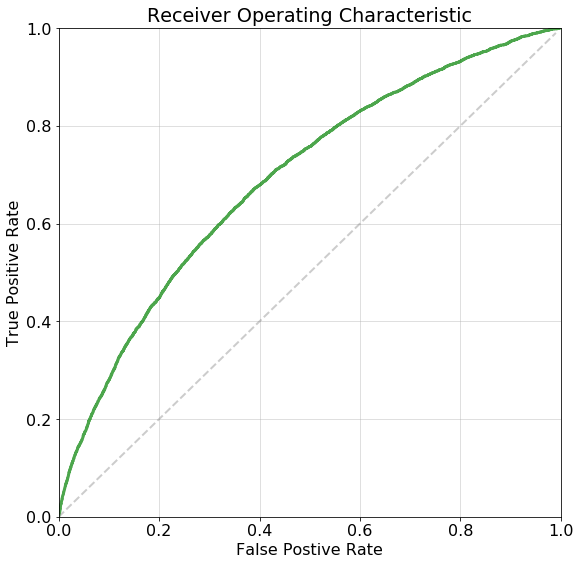

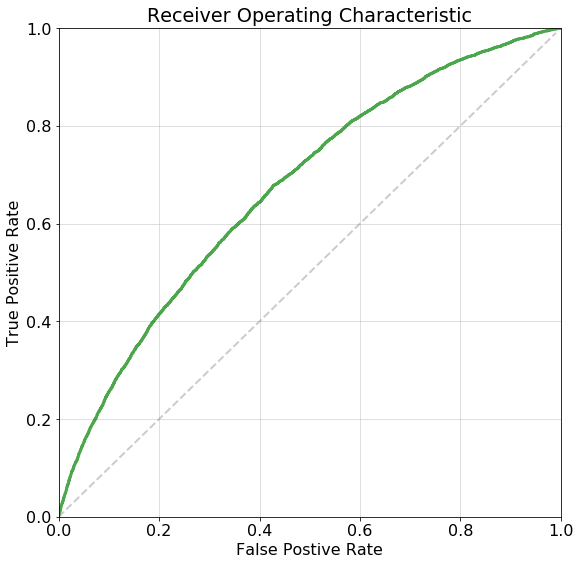

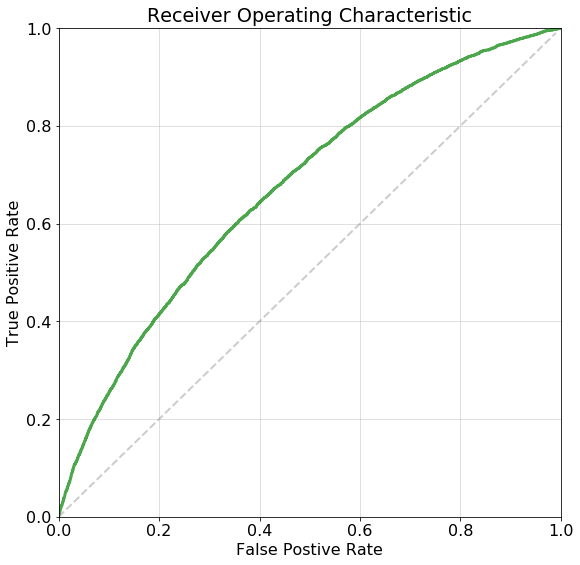

In [5]:
def eval_rfc(rfc):
    """ Evaluates a provided fitted Random Forest Classifier
        @param rfc: Random Forest Classifier"""
    # Basic Accuracy and Confussion Matrix
    print("Random Forest Classifier\nTrain Accuracy: {:.3f}\nTest Accuracy:  {:.3f}".format(
    rfc.score(app.X_train, app.y_train), rfc.score(app.X_test, app.y_test)))
    y_test_score = [p2 for p1, p2 in rfc.predict_proba(app.X_test)]
    fpr, tpr, thresholds = roc_curve(app.y_test, y_test_score)
    thresh = 0.1
    print("Confusion Matrix for {} threhold.".format(thresh))
    print(confusion_matrix(app.y_test, (np.array([p2 for p1, p2 in rfc.predict_proba(app.X_test)]) > thresh).astype("int")))
    matplotlib.rcParams.update({'font.size': 16})

    # AUC
    print("Area Under the Curve")
    print(roc_auc_score(app.y_test, y_test_score))

    # Plot ROC
    plt.figure(figsize=(9, 9))
    plt.plot(fpr, tpr, linewidth=3, alpha=0.7, color="g")
    plt.plot(np.array(range(100)) / 100.0, np.array(range(100)) / 100.0, 
             linestyle='--', linewidth=2, alpha=0.4, color="gray")
    plt.title("Receiver Operating Characteristic")
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Positive Rate")
    plt.ylim((0, 1.001))
    plt.xlim((0, 1.000))
    plt.grid(alpha=0.5)

eval_rfc(rfc)
eval_rfc(rfc_mo_s)
eval_rfc(rfc_mo_a)

## Neural Nets

In [12]:
# Generate data from Pandas dataframes
pd.DataFrame(app.X_train).to_csv("data/mx/x_train.csv", header=False, index=False)
pd.DataFrame(app.y_train).to_csv("data/mx/y_train.csv", header=False, index=False)
pd.DataFrame(app.X_test).to_csv("data/mx/x_test.csv", header=False, index=False)
pd.DataFrame(app.y_test).to_csv("data/mx/y_test.csv", header=False, index=False)

In [4]:
# Configuration
version = "1_0"
ctx = mx.gpu(0)

data_path = {"train_x": "data/mx/x_train.csv",
             "train_y": "data/mx/y_train.csv",
             "test_x":  "data/mx/x_test.csv",
             "test_y":  "data/mx/y_test.csv"}

train_batch_size = 50000
test_batch_size = 5000

learning_rate = 0.01
num_cols = n_components
minority_weight = 1
train_hist = []
num_epochs = 100
dt = "float32"
roc = None

# Define network
net = gluon.nn.Sequential(prefix='mlpc_')
with net.name_scope():
    net.add(gluon.nn.Dense(256, activation="tanh"))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Dropout(.25))
    net.add(gluon.nn.Dense(256, activation="tanh"))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Dropout(.25))
    net.add(gluon.nn.Dense(128, activation="tanh"))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Dropout(.25))
    net.add(gluon.nn.Dense(64, activation="tanh"))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Dropout(.25))
    net.add(gluon.nn.Dense(32, activation="tanh"))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Dropout(.25))
    net.add(gluon.nn.Dense(1, activation="sigmoid"))
    
# Save network
x = symbol.var("data")
y = net(x)
y.save("cd_net_{}.json".format(version))

# Intitalize parametes of the model
net.collect_params().initialize(mx.init.Normal(sigma=0.01), force_reinit=True, ctx=ctx)
# TODO: Add option to load existing parameters for network for checkpointing

# Add binary loss function
binary_cross_entropy = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# Define trainer
trainer = gluon.Trainer(net.collect_params(), "sgd", {"learning_rate": learning_rate})

# Helper methods
def train_data():
    """Gets training data based on data_path dict.
        @return CSV iterator for MXNET"""
    return(mx.io.CSVIter(data_csv=data_path["train_x"], label_csv=data_path["train_y"],
                        data_shape=(num_cols,), batch_size=train_batch_size, round_batch=False))
def test_data():
    """Gets test data based on data_path dict.
        @return CSV iterator for MXNET"""
    return(mx.io.CSVIter(data_csv=data_path["test_x"], label_csv=data_path["test_y"],
                         data_shape=(num_cols,), batch_size=test_batch_size, round_batch=False))

def load_net(name):
    """Loads old net.
        @param name (str): Old net's name excluding .params extension
        @returns Network parameters."""
    net.load_params(name + ".params", ctx=ctx)
    
def print_net():
    """Prints current net"""
    print("*" * 80)
    for k, v in net.collect_params().items():
        print("-" * 60)
        print(k)
        print(v.data())
    print("*" * 80)

def check_test():
    """ Gets ROC and AUC based on test.
        @returns Dict with fpr, tpr and auc.
    """
    start_time = time()
    y_pred = np.array([])
    y_train = np.array([])

    for batch in test_data():
        data = batch.data[0].as_in_context(ctx).astype(dt)
        label = batch.label[0].as_in_context(ctx).astype(dt)
        output = net(data)
        y_train = np.append(y_train, label.asnumpy())
        y_pred = np.append(y_pred, output.asnumpy())
    print("Range of thresh from: {} to: {}".format(np.min(y_pred), np.max(y_pred)))
    print("Accuracy check took: {} sec".format(time() - start_time))
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    prec_score = precision_score(y_train, y_pred > 0.5, pos_label=1, average="binary")
    return({"fpr": fpr, "tpr": tpr, "auc": auc_val, "prec_score": prec_score})

def get_minority(ctx):
    """ Given a context gets all the minority data.
        @param ctx: GPU or CPU Mxnet context.
        @return  All the minority events"""
    minority_events = np.array([])
    for batch in train_data():
        data = batch.data[0].asnumpy()
        label = batch.label[0].asnumpy()
        minority_events = np.append(minority_events, data[label > 0.5])
    print("Minority rows total: " + str(minority_events.shape[0] / num_cols))
    minority_events = minority_events.reshape([int(len(minority_events) / num_cols), num_cols])
    return(nd.array(minority_events, ctx))

## Train

In [ ]:
# Optional load old net and show params
load_net("cd_net_1_0.json")
print_net()

In [5]:
# Gets all minority events
minority_x = get_minority(ctx)
minority_y = nd.ones(minority_x.shape[0]).as_in_context(ctx)

# Runs optimization
print("Starting Net Fitting")
print("*" * 80)
for e in range(0, num_epochs):
    start_time = time()
    cumulative_loss = 0
    print("[", end="", flush=True) # Start progres bar
    for i, all_data in enumerate(train_data()):
        data = all_data.data[0].as_in_context(ctx).astype(dt)
        label = all_data.label[0].as_in_context(ctx).astype(dt)
        
        # Add in all of the minority in
        data = nd.concat(data,  minority_x, dim=0)
        label = nd.concat(label, minority_y, dim=0)
        
        # Compute loss and back propagate it + update params
        with autograd.record():
            output = net(data) # the forward iteration
            loss = binary_cross_entropy(output, label) * (minority_weight * label + 1)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
        
        # Progress bar addition...
        print("#", end="", flush=True)
    print("]", flush=True) # End progres bar
    
    # Compute ROC every 5 epochs
    if e % 5 == 0:
        roc = check_test()
    duration = time() - start_time
    print("Epoch {}. Epoch Loss: {}. Duration: {}. AUC: {}. Prec: {}".
          format(e, cumulative_loss, duration, roc["auc"], roc["prec_score"]))
    
    train_hist.append({"epoch": e, 
                       "duration": duration, 
                       "loss": cumulative_loss, 
                       "learning_rate": trainer.learning_rate,
                       "roc_metrics": roc})

Minority rows total: 20219.0
Starting Net Fitting
********************************************************************************
[#####]
Range of thresh from: 0.4995276629924774 to: 0.4995622932910919
Accuracy check took: 0.8352642059326172 sec
Epoch 0. Epoch Loss: 338897.84375. Duration: 6.545217037200928. AUC: 0.5026649737537243. Prec: 0.0
[

C:\Users\Dimitar Vlassarev\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#####]
Epoch 1. Epoch Loss: 338815.8828125. Duration: 5.510077238082886. AUC: 0.5026649737537243. Prec: 0.0
[#####]
Epoch 2. Epoch Loss: 338735.265625. Duration: 5.529895067214966. AUC: 0.5026649737537243. Prec: 0.0
[#####]
Epoch 3. Epoch Loss: 338644.4375. Duration: 5.497668981552124. AUC: 0.5026649737537243. Prec: 0.0
[#####]
Epoch 4. Epoch Loss: 338566.953125. Duration: 5.52548623085022. AUC: 0.5026649737537243. Prec: 0.0
[#####]
Range of thresh from: 0.4937528371810913 to: 0.5018309950828552
Accuracy check took: 0.9215703010559082 sec
Epoch 5. Epoch Loss: 338477.7109375. Duration: 6.579943418502808. AUC: 0.5911938849215038. Prec: 0.06493506493506493
[#####]
Epoch 6. Epoch Loss: 338406.9765625. Duration: 5.697310924530029. AUC: 0.5911938849215038. Prec: 0.06493506493506493
[#####]
Epoch 7. Epoch Loss: 338300.5234375. Duration: 5.634067535400391. AUC: 0.5911938849215038. Prec: 0.06493506493506493
[#####]
Epoch 8. Epoch Loss: 338212.8359375. Duration: 5.629602432250977. AUC: 0.5911938

[#####]
Epoch 58. Epoch Loss: 319145.4296875. Duration: 5.6221630573272705. AUC: 0.7314190498494958. Prec: 0.14950359323723675
[#####]
Epoch 59. Epoch Loss: 318829.27734375. Duration: 5.608772039413452. AUC: 0.7314190498494958. Prec: 0.14950359323723675
[#####]
Range of thresh from: 0.01068985927850008 to: 0.986631453037262
Accuracy check took: 0.851630687713623 sec
Epoch 60. Epoch Loss: 318570.84765625. Duration: 6.512981653213501. AUC: 0.7329431455184902. Prec: 0.14981086586024858
[#####]
Epoch 61. Epoch Loss: 318447.47265625. Duration: 5.625636339187622. AUC: 0.7329431455184902. Prec: 0.14981086586024858
[#####]
Epoch 62. Epoch Loss: 318225.91015625. Duration: 5.627126216888428. AUC: 0.7329431455184902. Prec: 0.14981086586024858
[#####]
Epoch 63. Epoch Loss: 318022.5234375. Duration: 5.625634431838989. AUC: 0.7329431455184902. Prec: 0.14981086586024858
[#####]
Epoch 64. Epoch Loss: 317855.203125. Duration: 5.81610369682312. AUC: 0.7329431455184902. Prec: 0.14981086586024858
[#####]


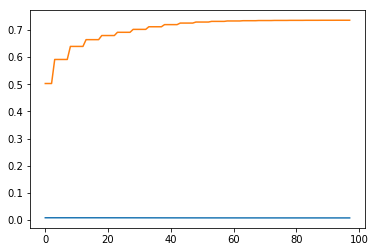

In [6]:
# Loss change plot
plt.plot([e["loss"] / 4E7 for i, e in enumerate(train_hist) if i >= 2])
plt.plot([e["roc_metrics"]["auc"] for i, e in enumerate(train_hist) if i >= 2])

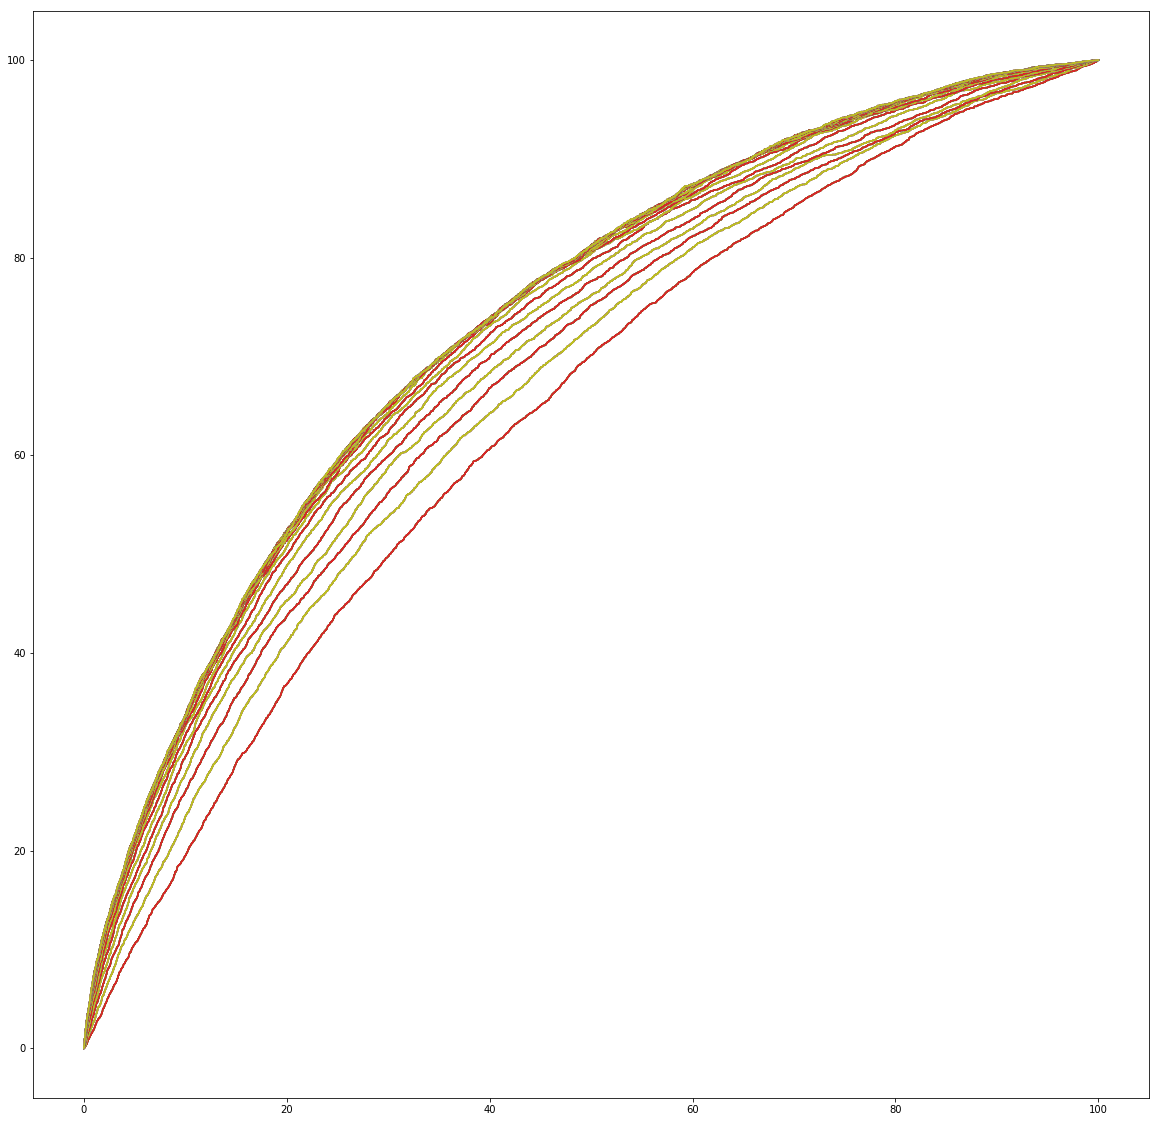

In [7]:
# Plots ROC from roc dict
plt.figure(figsize=(20,20))
for i, pt in enumerate(train_hist):
    if i > 10:
        plt.plot(100 * pt["roc_metrics"]["fpr"], 100 * pt["roc_metrics"]["tpr"])

In [8]:
# Save params
net.save_params("cd_net_{}.params".format(version))

In [9]:
# Save train hist
import pickle
with open("cd_net_{}.th".format(version), "wb") as output:
    pickle.dump(train_hist, output)

In [ ]:
# Load train hist
import pickle
with open("abs_net_{}.th".format(version), 'rb') as f:
    train_hist = pickle.load(f)

In [11]:
train_hist[-1]

{'duration': 5.627621650695801,
 'epoch': 99,
 'learning_rate': 0.01,
 'loss': 314116.01171875,
 'roc_metrics': {'auc': 0.7355969488941215,
  'fpr': array([0.00000000e+00, 3.34599234e-05, 3.34599234e-05, ...,
         9.99933080e-01, 9.99966540e-01, 1.00000000e+00]),
  'tpr': array([1.91314329e-04, 1.91314329e-04, 3.82628659e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}}

## Old Code to be Integrated

In [ ]:
# Load data into dataframes
application_train     = pd.read_csv(r"data/application_train.csv.zip")
# application_test      = pd.read_csv(r"data/application_test.csv.zip")
# bureau                = pd.read_csv(r"data/bureau.csv.zip")
# bureau_balance        = pd.read_csv(r"data/bureau_balance.csv.zip")
# credit_card_balance   = pd.read_csv(r"data/credit_card_balance.csv.zip")
# installments_payments = pd.read_csv(r"data/installments_payments.csv.zip")
# pos_cash_balance      = pd.read_csv(r"data/POS_CASH_balance.csv.zip")
# previous_application  = pd.read_csv(r"data/previous_application.csv.zip")
columns_description   = pd.read_csv(r"data/HomeCredit_columns_description.csv", encoding='cp1252')

## Display Column descriptions

In [ ]:
# Column descriptions
pd.options.display.max_rows = 500
display(columns_description[["Table", "Row", "Description", "Special"]])
pd.reset_option("max_rows")

In [ ]:
# Pick out string columns
cardinal_columns = application_train.select_dtypes([np.object]).columns
for col_name in cardinal_columns:
    col_data = application_train[col_name]
    print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

# One-hot encode all the cardinal columns
def clean_col_name(name):
    """
        Cleans column names from special characters and whitespaces.
        @param name (str): Input name
        @return name (str): Cleaned up name
    """
    
    name = name.upper()
    name = name.replace(",", "_")
    name = name.replace(" ", "_")
    name = name.replace("/", "_")
    name = name.replace(":", "_")
    return(name)

for col_name in cardinal_columns:
    dummy_cols = pd.get_dummies(application_train[col_name])
    dummy_cols.columns = ["{}_{}".format(col_name, clean_col_name(dummy_name)) for dummy_name in dummy_cols]
              
    application_train = application_train.merge(
        dummy_cols,
        left_index=True,
        right_index=True)
    application_train = application_train.drop(col_name, axis=1)

In [ ]:
application_train.describe()

In [ ]:
for col in application_train.columns:
    print(col)

In [ ]:
# Target data appears to be all present and only contain 0 and 1 values
y = application_train["TARGET"].copy()

In [ ]:
application_train["EXT_SOURCE_1"].describe()

In [ ]:
application_train[["NAME_CONTRACT_TYPE"]].merge(
    pd.get_dummies(application_train["NAME_CONTRACT_TYPE"]),
    left_index=True,
    right_index=True)

In [ ]:
X = application_train[["CNT_CHILDREN", 
                  "AMT_INCOME_TOTAL",
                  "AMT_CREDIT",
                  "AMT_ANNUITY",
                  "AMT_GOODS_PRICE",
                  "DAYS_BIRTH",
                  "DAYS_EMPLOYED"]].copy()

In [ ]:
mask = X.isna().apply(lambda row: not any(row), axis=1)

In [ ]:
X = X[mask].values
y = y[mask].values

In [ ]:
pca = PCA(n_components=2)
pca_model = pca.fit(X)